In [ ]:
## PROBLEM 1


In [34]:
#pip install wrds

In [43]:

import wrds
db=wrds.Connection(wrds_username='perusset')
#db.create_pgpass_file()


Loading library list...
Done


In [57]:
import pandas as pd
data=db.raw_sql("select  permco, date, prc, ret,vol "
           "from crsp.dsf "
           "where permco in (7) "
           "and date>='2001-01-01'"
            "and date<='2023-12-31'")
data.to_csv('test.csv', sep=';', index=False)
data = pd.read_csv("test.csv", sep=';') 

In [58]:
S_real = db.raw_sql("select  date,permco,ret "
           "from crsp.dsf "
           "where permco in (7,35048,8048,21446,20792) "
           "and date>='2001-01-01'"
            "and date<='2023-12-31'")

             date  permco       ret
0      2001-01-02   20792 -0.087353
1      2001-01-02    8048  0.000000
2      2001-01-03    8048  0.105187
3      2001-01-04    8048  0.010430
4      2001-01-05    8048  0.014194
...           ...     ...       ...
28920  2023-12-22   21446  0.007071
28921  2023-12-26   21446  0.004543
28922  2023-12-27   21446  0.000822
28923  2023-12-28   21446 -0.002259
28924  2023-12-29   21446  0.005558

[28925 rows x 3 columns]


In [67]:

# Load All Stocks at once
S_real = db.raw_sql("select  date,permco,ret "
           "from crsp.dsf "
           "where permco in (7,35048,8048,21446,20792) "
           "and date>='2001-01-01'"
            "and date<='2023-12-31'")
S_real = S_real.set_index(['date','permco'])['ret'].unstack('permco')
S_real = (S_real+1).cumprod() #get share price (proxy)
S_real.columns = ['AAPL','MSFT','GE','PG','GS']
S_real.to_csv('S_real.csv', sep=';', index=False)


OperationalError: (psycopg2.OperationalError) server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.
server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.

[SQL: select  date,permco,ret from crsp.dsf where permco in (7,35048,8048,21446,20792) and date>='2001-01-01'and date<='2023-12-31']
(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [60]:
## PROBLEM 2


In [61]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import display
pd.set_option('display.max_columns', 50)
pd.set_option('max_colwidth',40)


In [62]:
import os
os.chdir(r"C:\Users\perusset\Downloads\Investments\2024\Exercises\PS 1")

test = pd.read_csv("test.csv", sep=';',index_col='date')
S_real = pd.read_csv("S_real.csv", sep=';')
S_real.index = test.index

C:\Users\perusset\AppData\Local\Temp\ipykernel_18032\4194261639.py:38: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  S1 = S_real.resample(freq).last()


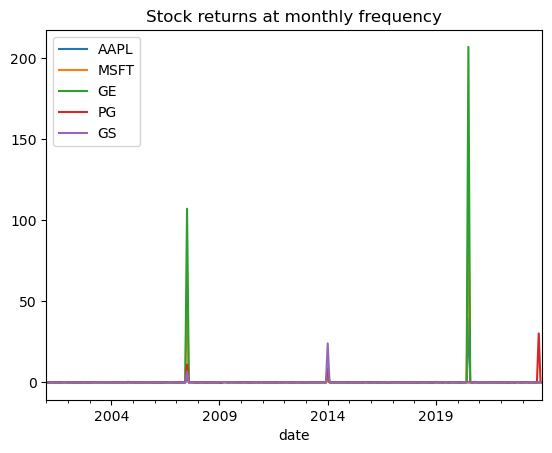

C:\Users\perusset\AppData\Local\Temp\ipykernel_18032\4194261639.py:38: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  S1 = S_real.resample(freq).last()


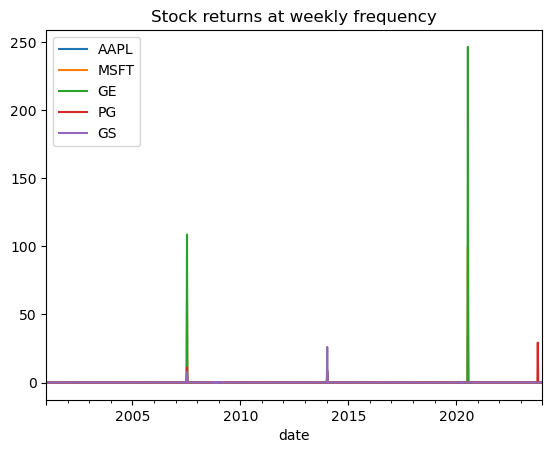

C:\Users\perusset\AppData\Local\Temp\ipykernel_18032\4194261639.py:38: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  S1 = S_real.resample(freq).last()


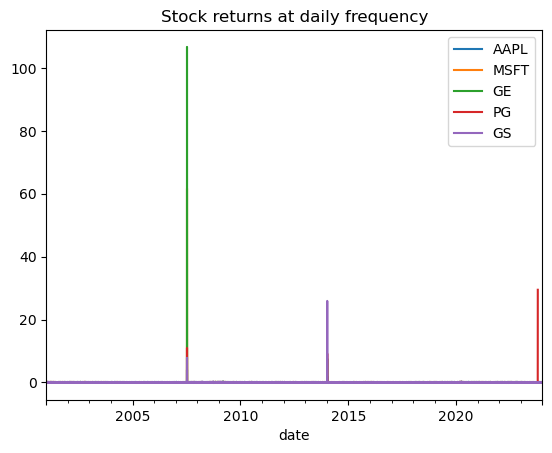

In [63]:

data_sources = ['REAL']
S = S_real
ticker_list = ['AAPL','MSFT','GE','PG','GS']
N_assets = len(S.columns)

S_real.index = pd.to_datetime(S_real.index)  # First, ensure the index is a DateTimeIndex
S_real.index = S_real.index.to_period('D') # To match with index type of S_sim and to use the function S.resample()


#Define the sampling frequencies: M, W, or D
samp_freq = ['M','W','D']
descr_freq = {'M': 'monthly', 'W': 'weekly', 'D': 'daily'}
label_freq = {'M': '1. M', 'W': '2. W', 'D': '3. D'}
descr_window = {'M': '12-month', 'W': '52-Week', 'D': '365-days'}
N_periods = {'REAL': {'M': 12, 'W': 52, 'D': 252}} #  for real data, use e.g. 252 days for number of daily observations
Nmin_periods = {'REAL': {'M': 10, 'W': 50, 'D': 100}} #  for real data, use e.g. 100 days for number of daily observations

index_stats = ['count','mean','std','min','25%','50%','75%','max']
    
p_stats={}
p_mean_vol={}
p_est_mean={}
p_est_var={}
p_rolling_mean={}
p_rolling_std={}
data = []
    
data_source='REAL'

for freq in samp_freq: 


    #Auxiliary data
    N_per = N_periods[data_source][freq]
    Nmin_per = Nmin_periods[data_source][freq]

    #(a) Compute simple-returns at new frequency
    S1 = S_real.resample(freq).last()
    ret = S1/S1.shift(1)-1
    ret.plot(label=descr_freq[freq],title='Stock returns at '+descr_freq[freq]+' frequency')
    plt.show()

    #(b) Get some summary statistics
    tmp = ret.describe()
    stats = tmp.values
    p_stats[label_freq[freq]] = pd.DataFrame(stats, columns=ticker_list,index=index_stats)    

    #(c) Annualized mean and std. deviation
    mean_vol = np.array(ret.mean()*N_per)
    mean_vol = np.vstack((mean_vol,ret.std()*np.sqrt(N_per)))
    p_mean_vol[label_freq[freq]] = pd.DataFrame(mean_vol, columns=ticker_list,index=['ann. sample mean','ann. sample std.dev.'])

    #(d) Time-series of the annualized rolling mean and std. dev. of simple-returns
    p_rolling_mean[freq]= ret.rolling(window=N_per,min_periods=Nmin_per).mean()*N_per
    p_rolling_std[freq]= ret.rolling(window=N_per,min_periods=Nmin_per).std()*np.sqrt(N_per)

    

In [64]:
    
#(b) Display summary statistics
#--------------------------------------------------
p_stats_m = p_stats['1. M']
p_stats_w =  p_stats['2. W']
p_stats_d = p_stats['3. D']
for ind in p_stats_m.index.difference(['count']): 
    p_stats_m.loc[ind] = p_stats_m.loc[ind].apply(lambda n: '{0:.2%}'.format(n))
p_stats_m.loc['count'] = p_stats_m.loc['count'].apply(lambda n: '{:10}'.format(n))
print('Month:')
display(p_stats_m)
for ind in p_stats_w.index.difference(['count']): 
    p_stats_w.loc[ind] = p_stats_w.loc[ind].apply(lambda n: '{0:.2%}'.format(n))
p_stats_w.loc['count'] = p_stats_w.loc['count'].apply(lambda n: '{:10}'.format(n))
print('Week:')
display(p_stats_w)
for ind in p_stats_d.index.difference(['count']): 
    p_stats_d.loc[ind] = p_stats_d.loc[ind].apply(lambda n: '{0:.2%}'.format(n))
p_stats_d.loc['count'] = p_stats_d.loc['count'].apply(lambda n: '{:10}'.format(n))
print('Day:')
display(p_stats_d)
        

Month:


C:\Users\perusset\AppData\Local\Temp\ipykernel_18032\3019205255.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-3.32%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  p_stats_m.loc[ind] = p_stats_m.loc[ind].apply(lambda n: '{0:.2%}'.format(n))
C:\Users\perusset\AppData\Local\Temp\ipykernel_18032\3019205255.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-3.51%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  p_stats_m.loc[ind] = p_stats_m.loc[ind].apply(lambda n: '{0:.2%}'.format(n))
C:\Users\perusset\AppData\Local\Temp\ipykernel_18032\3019205255.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-3.95%' has dtype incompatible with float64, please

,AAPL,MSFT,GE,PG,GS
count,275.0,275.0,275.0,275.0,275.0
mean,19.37%,62.00%,117.11%,18.97%,12.18%
std,240.48%,732.76%,1404.63%,200.41%,150.62%
min,-32.96%,-16.34%,-27.68%,-11.61%,-27.50%
25%,-3.32%,-3.51%,-3.95%,-1.97%,-4.93%
50%,3.38%,2.00%,0.15%,0.90%,1.55%
75%,9.76%,5.84%,4.78%,3.74%,6.55%
max,3962.64%,10573.04%,20711.44%,3023.56%,2406.46%


Week:


C:\Users\perusset\AppData\Local\Temp\ipykernel_18032\3019205255.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2.10%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  p_stats_w.loc[ind] = p_stats_w.loc[ind].apply(lambda n: '{0:.2%}'.format(n))
C:\Users\perusset\AppData\Local\Temp\ipykernel_18032\3019205255.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.63%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  p_stats_w.loc[ind] = p_stats_w.loc[ind].apply(lambda n: '{0:.2%}'.format(n))
C:\Users\perusset\AppData\Local\Temp\ipykernel_18032\3019205255.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.93%' has dtype incompatible with float64, ple

,AAPL,MSFT,GE,PG,GS
count,1199.0,1199.0,1199.0,1199.0,1199.0
mean,4.01%,13.80%,30.31%,4.32%,3.07%
std,99.20%,337.20%,777.99%,94.17%,78.78%
min,-24.31%,-18.31%,-20.46%,-16.14%,-30.62%
25%,-2.10%,-1.63%,-1.93%,-1.00%,-2.25%
50%,0.75%,0.28%,0.03%,0.23%,0.29%
75%,3.42%,2.23%,2.21%,1.53%,2.66%
max,3401.67%,9959.92%,24647.25%,2930.16%,2610.78%


Day:


C:\Users\perusset\AppData\Local\Temp\ipykernel_18032\3019205255.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.96%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  p_stats_d.loc[ind] = p_stats_d.loc[ind].apply(lambda n: '{0:.2%}'.format(n))
C:\Users\perusset\AppData\Local\Temp\ipykernel_18032\3019205255.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.79%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  p_stats_d.loc[ind] = p_stats_d.loc[ind].apply(lambda n: '{0:.2%}'.format(n))
C:\Users\perusset\AppData\Local\Temp\ipykernel_18032\3019205255.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.86%' has dtype incompatible with float64, ple

,AAPL,MSFT,GE,PG,GS
count,4531.0,4531.0,4531.0,4531.0,4531.0
mean,0.23%,1.46%,2.55%,1.14%,0.81%
std,6.90%,91.63%,158.94%,48.64%,40.26%
min,-17.17%,-11.71%,-12.79%,-8.74%,-13.92%
25%,-0.96%,-0.79%,-0.86%,-0.51%,-0.97%
50%,0.05%,0.04%,0.00%,0.04%,0.01%
75%,1.19%,0.94%,0.89%,0.60%,1.07%
max,397.73%,6166.16%,10671.64%,2946.44%,2591.36%


In [65]:
    
#(c) Display annualized mean and standard deviation
#--------------------------------------------------

p_mean_vol_m = p_mean_vol['1. M']
p_mean_vol_w =  p_mean_vol['2. W']
p_mean_vol_d = p_mean_vol['3. D']
for ind in p_mean_vol_m.index: 
    p_mean_vol_m.loc[ind] = p_mean_vol_m.loc[ind].apply(lambda n: '{0:.2%}'.format(n))
print('Month:')
display(p_mean_vol_m)
for ind in p_mean_vol_w.index: 
    p_mean_vol_w.loc[ind] = p_mean_vol_w.loc[ind].apply(lambda n: '{0:.2%}'.format(n))
print('Week:') 
display(p_mean_vol_w)
for ind in p_mean_vol_d.index: 
    p_mean_vol_d.loc[ind] = p_mean_vol_d.loc[ind].apply(lambda n: '{0:.2%}'.format(n))  
print('Day:')
display(p_mean_vol_d)
    

Month:


C:\Users\perusset\AppData\Local\Temp\ipykernel_18032\3370310447.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '232.46%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  p_mean_vol_m.loc[ind] = p_mean_vol_m.loc[ind].apply(lambda n: '{0:.2%}'.format(n))
C:\Users\perusset\AppData\Local\Temp\ipykernel_18032\3370310447.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '744.01%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  p_mean_vol_m.loc[ind] = p_mean_vol_m.loc[ind].apply(lambda n: '{0:.2%}'.format(n))
C:\Users\perusset\AppData\Local\Temp\ipykernel_18032\3370310447.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1405.33%' has dtype incompatible with

,AAPL,MSFT,GE,PG,GS
ann. sample mean,232.46%,744.01%,1405.33%,227.63%,146.17%
ann. sample std.dev.,833.03%,2538.36%,4865.76%,694.26%,521.76%


Week:


C:\Users\perusset\AppData\Local\Temp\ipykernel_18032\3370310447.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '208.40%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  p_mean_vol_w.loc[ind] = p_mean_vol_w.loc[ind].apply(lambda n: '{0:.2%}'.format(n))
C:\Users\perusset\AppData\Local\Temp\ipykernel_18032\3370310447.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '717.44%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  p_mean_vol_w.loc[ind] = p_mean_vol_w.loc[ind].apply(lambda n: '{0:.2%}'.format(n))
C:\Users\perusset\AppData\Local\Temp\ipykernel_18032\3370310447.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1576.25%' has dtype incompatible w

,AAPL,MSFT,GE,PG,GS
ann. sample mean,208.40%,717.44%,1576.25%,224.60%,159.60%
ann. sample std.dev.,715.35%,2431.56%,5610.17%,679.06%,568.06%


Day:


C:\Users\perusset\AppData\Local\Temp\ipykernel_18032\3370310447.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '57.03%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  p_mean_vol_d.loc[ind] = p_mean_vol_d.loc[ind].apply(lambda n: '{0:.2%}'.format(n))
C:\Users\perusset\AppData\Local\Temp\ipykernel_18032\3370310447.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '367.42%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  p_mean_vol_d.loc[ind] = p_mean_vol_d.loc[ind].apply(lambda n: '{0:.2%}'.format(n))
C:\Users\perusset\AppData\Local\Temp\ipykernel_18032\3370310447.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '643.25%' has dtype incompatible wit

,AAPL,MSFT,GE,PG,GS
ann. sample mean,57.03%,367.42%,643.25%,286.38%,204.11%
ann. sample std.dev.,109.58%,1454.56%,2523.11%,772.07%,639.05%


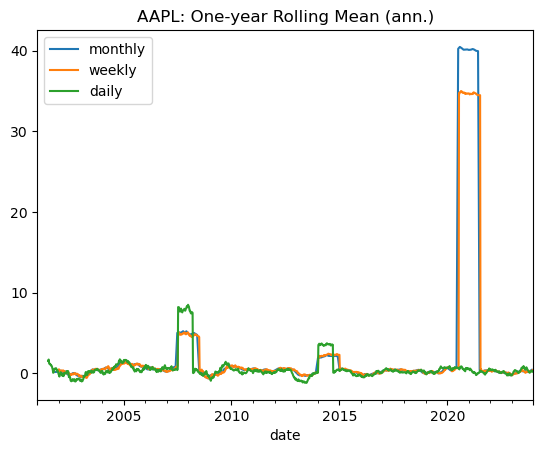

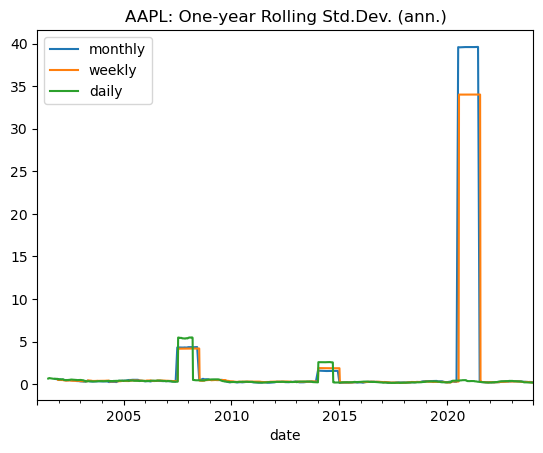

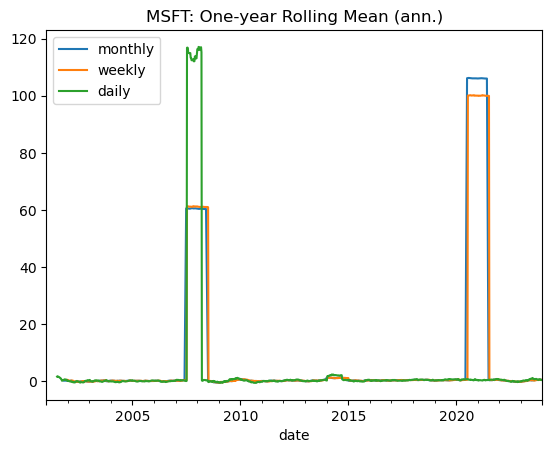

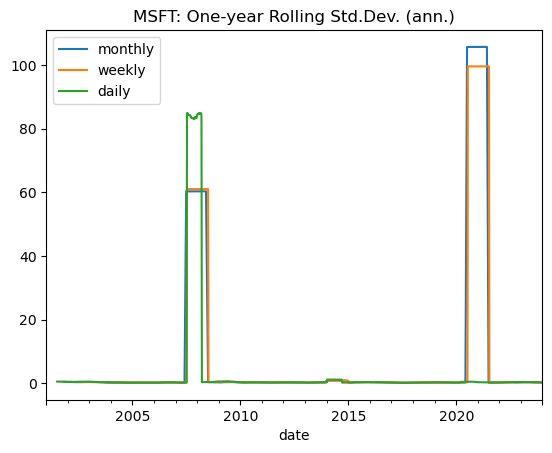

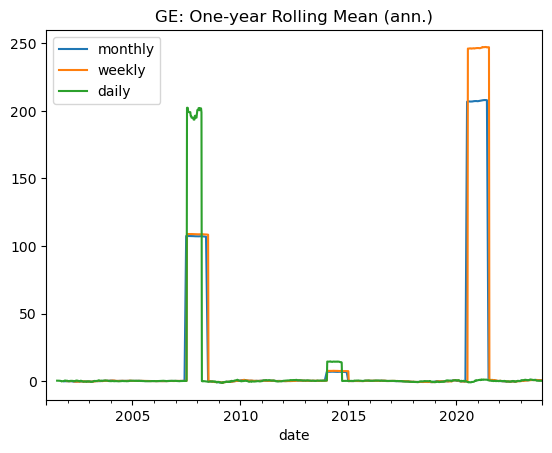

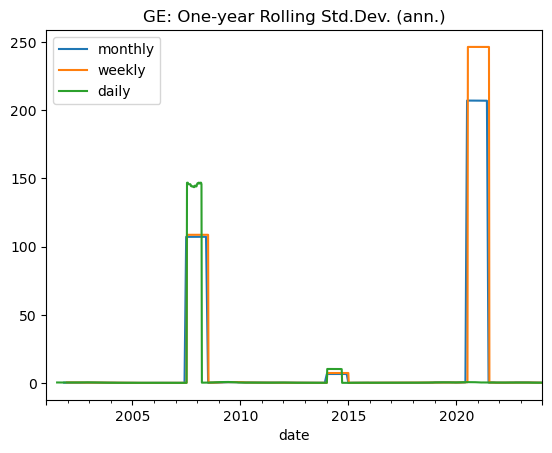

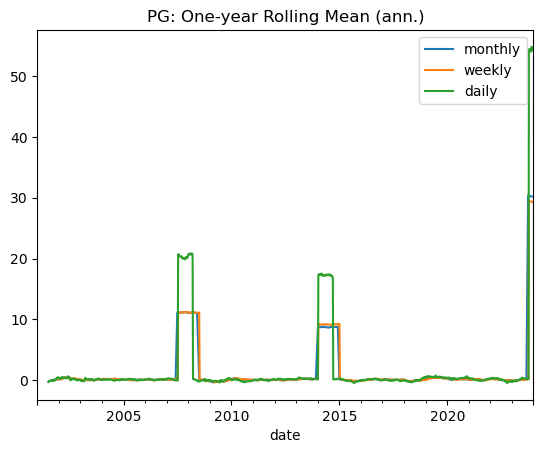

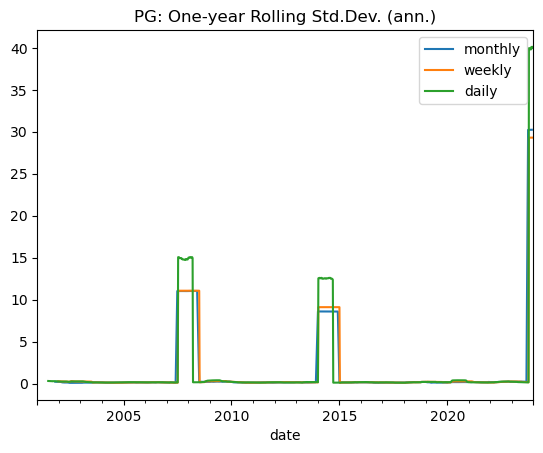

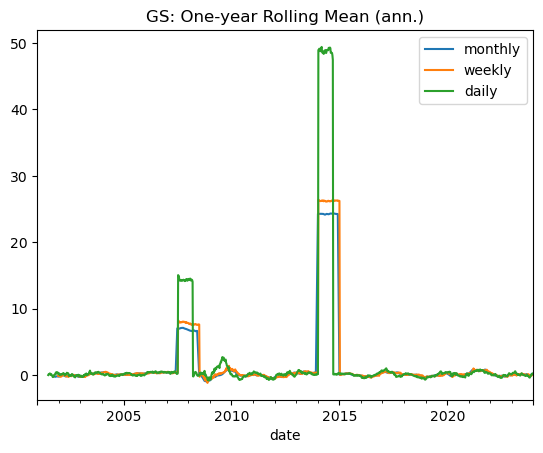

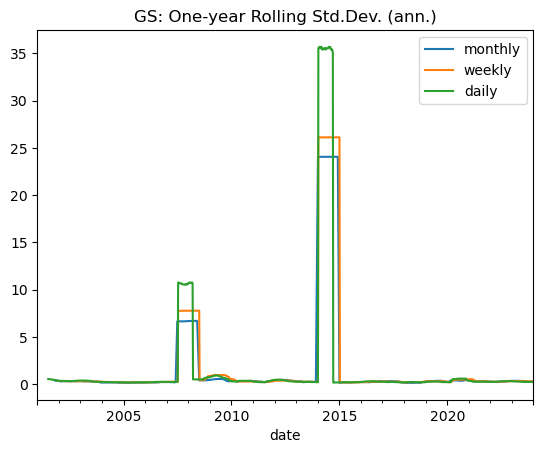

In [66]:
#(d) Display annualized mean and standard deviation
#--------------------------------------------------
for asset in ticker_list: 
    for freq in samp_freq: 
        RollingMean = p_rolling_mean[freq][asset]
        RollingMean.plot(label=descr_freq[freq])
    plt.title(asset+': One-year Rolling Mean (ann.)')
    plt.legend()
    plt.show()
    for freq in samp_freq: 
        RollingStd = p_rolling_std[freq][asset]
        RollingStd.plot(label=descr_freq[freq])
    plt.title(asset+': One-year Rolling Std.Dev. (ann.)')
    plt.legend()
    plt.show()  